In [1]:
import pandas as pd

data = pd.read_csv("Netflix.csv")
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


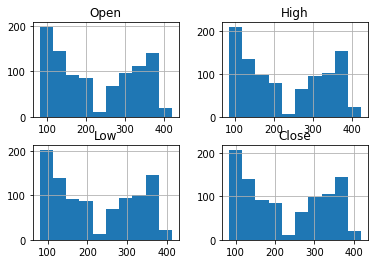

In [3]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]
data_used["Close"] = data["Close"]
hist = data_used.hist()
plt.show()

데이터의 Open, High, Low, Close를 분석한 결과 값의 범위가 100부터 400까지 넓게 형성되어 있는 것을 확인할 수 있다. 이때 출력값의 범위가 커지면 오차의 범위가 커져 가중치 수렴에 안 좋은 영향을 미칠 수 있기 때문에, 원활한 학습을 위해 값의 범위를 0부터 1까지로 정규화할 것이다.

In [4]:
import numpy as np

from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv("Netflix.csv")

        self.data = self.csv.iloc[:, 1:4].values
        self.data = self.data / np.max(self.data)
        
        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)
    
    def __len__(self):
        return len(self.data) - 30
    
    def __getitem__(self, i):
        data = self.data[i:i+30]
        label = self.label[i+30]
        
        return data, label

self.data는 입력 데이터로 Open(개장가), High(최고가), Low(최저가)를 의미하며, self.label은 타겟 데이터로 Close(종가)를 의미한다. 각 수치를 np.max로 나눠줌으로써 min-max normalization을 진행하였다. 또한 30일치 주가 정보를 묶어서 data로 받고, 그 이후 31일차 종가를 label로 설정하였다.

In [5]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        
        self.relu = nn.ReLU()
    
    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)
        
        x = torch.reshape(x, (x.shape[0], -1))
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        x = torch.flatten(x)
        
        return x

RNN에서 input_size=3은 특징 개수(개장가, 최고가, 최저가)를 의미하고, hidden_size는 RNN층에서 각 시점에서의 차원을 의미한다. num_layers는 얼마나 깊은 수준의 RNN을 실행할지 정해주는 척도이다.

In [6]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)
dataset = Netflix()

In [7]:
loader = DataLoader(dataset, batch_size=32)

In [8]:
optim = Adam(params=model.parameters(), lr=0.0001)

In [9]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optim.step()
        
        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")
        
torch.save(model.state_dict(), "./rnn.pth")

epoch199 loss:0.0005603056051768363: 100%|██████████| 30/30 [00:00<00:00, 72.86it/s] 


In [10]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)

preds = []
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load("rnn.pth", map_location=device))
    
    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())
        
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        total_loss += loss/len(loader)

total_loss.item()

0.0013032390270382166

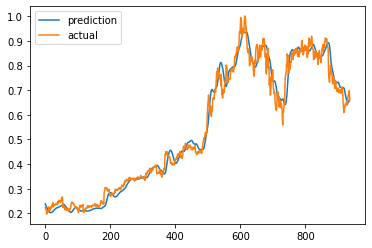

In [11]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()

RNN으로 예측한 값을 그래프로 확인해본 결과 실제 값과의 오차가 거의 없음을 확인할 수 있다.